### Imports

In [46]:
import pandas as pd
import os
from pathlib import Path
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Input Raw File and Decoder File

In [47]:
file = "LIV_53_QCHZ5_DNS-LIVTKCOD_LCRVCOD250-DNS_raw20250224135854.csv"
decoder_file = "QC WAFER_LAYOUT 24Dec.csv"

# Define the current script's directory
current_dir = Path(os.getcwd())

# Move to the root directory
root_dir = current_dir.parents[0]  # Adjust the number based on your folder structure

# Define the path to the required subfolder
file_path = root_dir / "LIV_Raw_Files" / file
decoder_file_path = root_dir / "decoders" / decoder_file

# Read the CSV file, skipping the first 19 rows
df = pd.read_csv(file_path, skiprows=19)

# Read the CSV file again to extract the second row
header_df = pd.read_csv(file_path, nrows=2)

# Extract the wafer id from the second row
wafer_id = header_df.iloc[1, 1]

# Print the wafer id for verification
print(f"Wafer ID: {wafer_id}")

# Get the directory of the file
folder = file_path.parent
print(f"Directory: {folder}")

# df.head(5)

Wafer ID: QCHZ5
Directory: c:\Users\762093\OneDrive - Seagate Technology\Documents\LIV\liv-cod-algorithm\LIV_Raw_Files


# Transform Data to Desired Raw Sweep Format

- selects required columns
- transposes
- stacks data in tall format
- adds in device coords from decoder file

In [54]:
# Transforming Raw File Code


warnings.filterwarnings("ignore")

# Get column names
col_names = df.columns



# Find columns containing "Vf" or "PD"


selected_cols = [col for col in col_names if "Vf" in col or "PD" in col]



# Subset the data frame with selected columns


df_subset = df[selected_cols]



# Find and delete columns containing "Vf@" or "PD@"


cols_to_delete = [col for col in df_subset.columns if "Vf@" in col or "PD@" in col]


df_subset.drop(columns=cols_to_delete, inplace=True)



# Transpose the data frame
df_transposed = df_subset.transpose()

# Reset index to make the transposed columns into rows
df_transposed.reset_index(inplace=True)

# Add a new row at the top with the desired titles
new_columns = ["Label"] + list(range(1, len(df_transposed.columns)))
df_transposed.columns = new_columns
df_transposed.loc[-1] = new_columns  # Add the new row at the top
df_transposed.index = df_transposed.index + 1  # Shift the index
df_transposed = df_transposed.sort_index()  # Sort by index to place the new row at the top

# Display the first 10 rows of df_transposed
df_transposed.head(10)
# df_subset.head(10)

# Split transposed table into Vf and PD data tables
df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")]
df_pd = df_transposed[df_transposed["Label"].str.contains("PD")]
# df_vf.head(10)
# df_pd.head(10)

# Drop the 'Label' column
df_vf.drop(columns=["Label"], inplace=True)
df_pd.drop(columns=["Label"], inplace=True)

# learn data dimensions
n_meas = df_vf.shape[0]
print(f"Number of Current Measurements per Device: {n_meas}")
n_devices = df_vf.shape[1]
print(f"Number of Devices: {n_devices}")

# Concatenate all Voltage columns into one
df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(
    name="Vf"
)

# Create TOUCHDOWN column
df_concat_vf["TOUCHDOWN"] = [i // n_meas + 1 for i in range(n_meas * n_devices)]

# Concatenate all PD columns into one
df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(
    name="PD"
)

# Cartesian join of Vf and PD data tables
df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)
# df_raw_sweeps.head(270)

# Add device coordinates from original RAW file


if "TOUCHDOWN" in df.columns and "STX_WAFER_X_UM" in df.columns and "STX_WAFER_Y_UM" in df.columns:
    df_raw_sweeps = df_raw_sweeps.merge(
        df[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left"
    )
else:
    print("Required columns for merging device coordinates are missing in the original RAW file.")


if decoder_file_path.exists():
    df_decoder = pd.read_csv(decoder_file_path)
    # Update with decoder to get TE_LABEL etc.
    if "YMIN" in df_decoder.columns and "XMIN" in df_decoder.columns:

        df_raw_sweeps = df_raw_sweeps.merge(
            df_decoder[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
            left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
            right_on=["YMIN", "XMIN"],
            how="left",
        ).drop(columns=["YMIN", "XMIN"])
    else:
        print("Required columns for merging decoder data are missing in the decoder file.")
else:
    print(f"Decoder file not found at {decoder_file_path}")


# Rename the columns
df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)


# Add current column as a repeating sequence of length n_meas
df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]


# Display the first 10 rows of df_raw_sweeps
df_raw_sweeps.head(379500)

Number of Current Measurements per Device: 250
Number of Devices: 1288


,Vf,TOUCHDOWN,PD,X_UM,Y_UM,TE_LABEL,TYPE,LDI_mA
0,1.273670,1,0.276224,-32339,-48416,64N6V,BL LASER,1
1,1.398251,1,0.276224,-32339,-48416,64N6V,BL LASER,2
2,1.447446,1,0.276224,-32339,-48416,64N6V,BL LASER,3
3,1.473689,1,0.270127,-32339,-48416,64N6V,BL LASER,4
4,1.496223,1,0.267079,-32339,-48416,64N6V,BL LASER,5
...,...,...,...,...,...,...,...,...
321995,2.682792,1288,0.318898,41067,-60599,70C05,SILC,246
321996,2.686199,1288,0.318898,41067,-60599,70C05,SILC,247
321997,2.690147,1288,0.317374,41067,-60599,70C05,SILC,248
321998,2.693864,1288,0.317374,41067,-60599,70C05,SILC,249


# Delta Method COD Algorithm

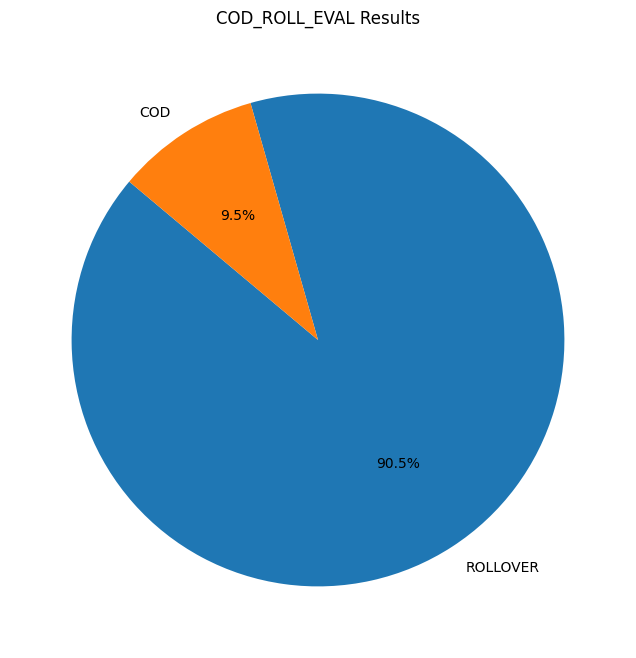

In [60]:
# Calculate dV/dI
df_raw_sweeps["dV/dI"] = (df_raw_sweeps["Vf"].diff()) / (df_raw_sweeps["LDI_mA"].diff())

# Calculate dP/dI
df_raw_sweeps["DP/DI"] = (df_raw_sweeps["PD"].diff()) / (df_raw_sweeps["LDI_mA"].diff())

# Calculate MAX_PD
df_raw_sweeps["MAX_PD"] = df_raw_sweeps.groupby(["TE_LABEL"])["PD"].transform("max")

# Calculate MEAN_PD
df_raw_sweeps["MEAN_PD"] = df_raw_sweeps.groupby(["TE_LABEL"])["PD"].transform("mean")

# Calculate DELTA
df_raw_sweeps["DELTA"] = df_raw_sweeps["MEAN_PD"] - df_raw_sweeps["DP/DI"].abs()

# Calculate MIN_DELTA
df_raw_sweeps["MIN_DELTA"] = df_raw_sweeps.groupby(["TE_LABEL"])["DELTA"].transform("min")

# Calculate COD_ROLL_EVAL
conditions = [(df_raw_sweeps["MIN_DELTA"] > 0.4), (df_raw_sweeps["MAX_PD"] < 0.2)]
choices = ["ROLLOVER", "NO LASER"]
df_raw_sweeps["COD_ROLL_EVAL"] = np.select(conditions, choices, default="COD")

# Calculate DEV_CURR_AT_ROLLOVER
df_raw_sweeps["DEV_CURR_AT_ROLLOVER"] = np.where(
    (df_raw_sweeps["PD"] == df_raw_sweeps["MAX_PD"])
    & (df_raw_sweeps["COD_ROLL_EVAL"] == "ROLLOVER"),
    df_raw_sweeps["LDI_mA"],
    np.nan,
)

# Calculate DEV_CURR_AT_SPD
df_raw_sweeps["DEV_CURR_AT_SPD"] = np.where(
    (df_raw_sweeps["PD"] == df_raw_sweeps["MAX_PD"]) & (df_raw_sweeps["COD_ROLL_EVAL"] == "COD"),
    df_raw_sweeps["LDI_mA"],
    np.nan,
)

# Calculate CURRENT_AT_ROLLOVER
df_raw_sweeps["CURRENT_AT_ROLLOVER"] = df_raw_sweeps.groupby(["TE_LABEL"])[
    "DEV_CURR_AT_ROLLOVER"
].transform("median")

# Calculate CURRENT_AT_SPD
df_raw_sweeps["CURRENT_AT_SPD"] = df_raw_sweeps.groupby(["TE_LABEL"])["DEV_CURR_AT_SPD"].transform(
    "median"
)

# Create COD Summary table
cod_summary = (
    df_raw_sweeps.groupby("TE_LABEL")
    .agg(
        {
            "WAFER_ID": "first",
            "X_UM": "first",
            "Y_UM": "first",
            "COD_ROLL_EVAL": "first",
            "MAX_PD": "first",
            "MEAN_PD": "first",
            "MIN_DELTA": "first",
            "CURRENT_AT_ROLLOVER": "first",
            "CURRENT_AT_SPD": "first",
        }
    )
    .reset_index()
)


# Plot a pie chart of the COD_ROLL_EVAL results with percentages annotated
cod_roll_eval_counts = cod_summary["COD_ROLL_EVAL"].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(cod_roll_eval_counts, labels=cod_roll_eval_counts.index, autopct="%1.1f%%", startangle=140)
plt.title("COD_ROLL_EVAL Results")
plt.show()

# Display the first 10 rows of the COD Summary table
cod_summary.head(1288)

# Raw Sweep Plotting

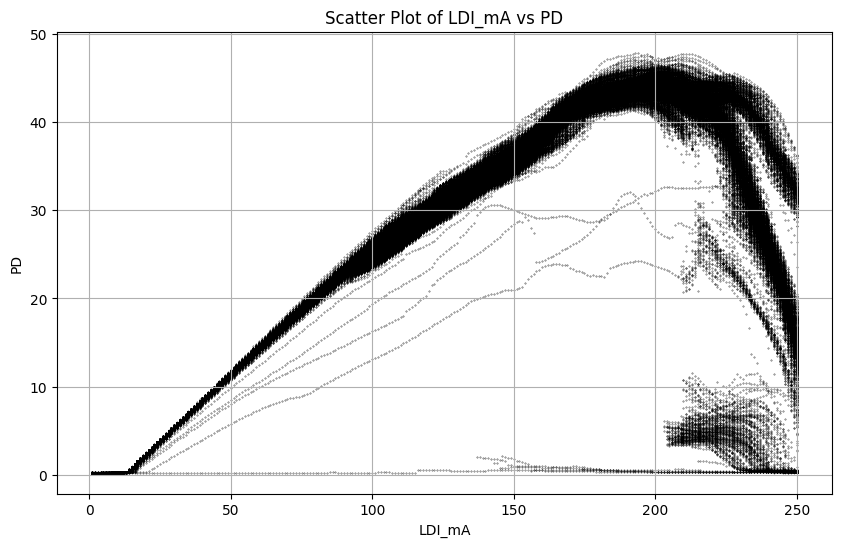

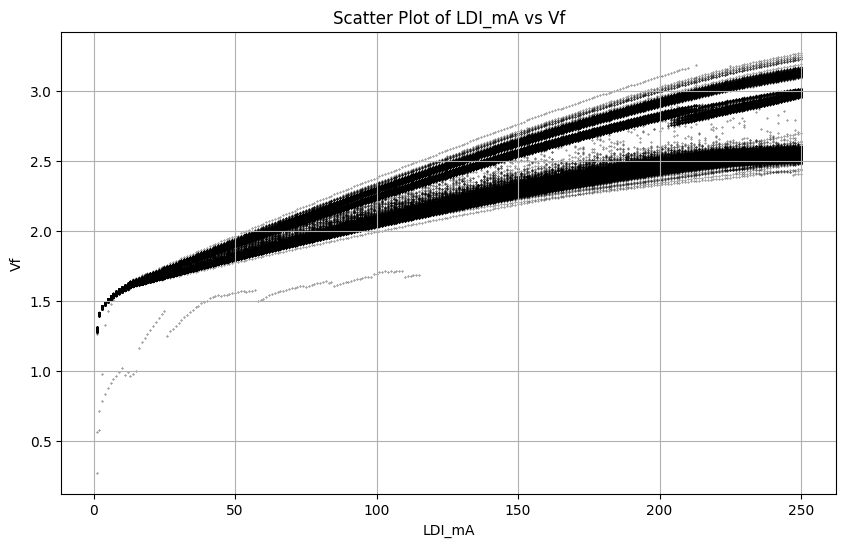

In [61]:
# Scatter plot of LDI_mA against PD
plt.figure(figsize=(10, 6))
plt.scatter(df_raw_sweeps["LDI_mA"], df_raw_sweeps["PD"], alpha=0.8, s=0.1, c="k")
plt.title("Scatter Plot of LDI_mA vs PD")
plt.xlabel("LDI_mA")
plt.ylabel("PD")
plt.grid(True)
plt.show()

# Scatter plot of LDI_mA against Vf
plt.figure(figsize=(10, 6))
plt.scatter(df_raw_sweeps["LDI_mA"], df_raw_sweeps["Vf"], alpha=0.8, s=0.1, c="k")
plt.title("Scatter Plot of LDI_mA vs Vf")
plt.xlabel("LDI_mA")
plt.ylabel("Vf")
plt.grid(True)
plt.show()